In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.constants import physical_constants
from scipy.integrate import solve_ivp

In [2]:
#Constants
energy_zero      = -0.0005*physical_constants['Bohr magneton'][0]
energy_one       = +0.0005*physical_constants['Bohr magneton'][0]
tunnel_energy    = 1.0
relaxation_gamma = 1/(111e-9)

#Basis States
basis_states = [np.array([[1],[0]]), np.array([[0],[1]])]

#Hamiltonian of electron spin in magnetic field
hamiltonian = np.array([[energy_zero, 0],[0,energy_one]])

# Create density matrix with initial conditions
# - Create as vector for using solve_ivp
density_matrix_init  = np.array([1/2, 1/2, 1/2, 1/2]).astype(complex)

In [3]:
# Helper Functions
def dagger(state):
    return np.transpose(np.conj(state))

def commutator(matA, matB):
    return (np.matmul(matA, matB) - np.matmul(matB, matA))

def anticommutator(matA, matB):
    return (np.matmul(matA, matB) + np.matmul(matB, matA))

def dissipator(gamma, density_matrix):
    rho     = density_matrix.reshape((2,2))     # Reshaping the density operator into a matrix for multiplication
    jump_op = basis_states[0]@basis_states[1].T # Which jump operator is this?
    dissipation_term  = gamma*(jump_op@rho@dagger(jump_op))
    dissipation_term -= gamma*(0.5)*anticommutator(dagger(jump_op)@jump_op, rho)
    return dissipation_term

def density_dot(time, density_matrix):
    # Von Neumann Contribution
    current_density_dot = (-1j/const.hbar)*commutator(hamiltonian, density_matrix.reshape((2,2)))
    # Dissispator Contribution
    current_density_dot += dissipator(relaxation_gamma, density_matrix)
    return (current_density_dot.reshape((1,-1))) #Reshape into a vector for the solve_ivp() function

In [4]:
# Solving the Lindblad Equation

# Time Parameters
T_MIN = 0
T_MAX = 600e-9
# Solve the initial value problem
sol = solve_ivp(density_dot, [T_MIN, T_MAX], density_matrix_init.reshape((4,)), max_step=T_MAX/1000)

In [5]:
# Extract Populations
density_matrix_00 = sol.y[0]
density_matrix_01 = sol.y[1]
density_matrix_10 = sol.y[2]
density_matrix_11 = sol.y[3]

# Calculate Purity at each time step
purity = []
for index in range(len(sol.t)):
    current_density_matrix = np.array([[sol.y[0,index],sol.y[1,index]],[sol.y[2,index],sol.y[3,index]]])
    current_purity = np.trace(current_density_matrix@current_density_matrix)
    purity.append(current_purity)

/home/niall/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/niall/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


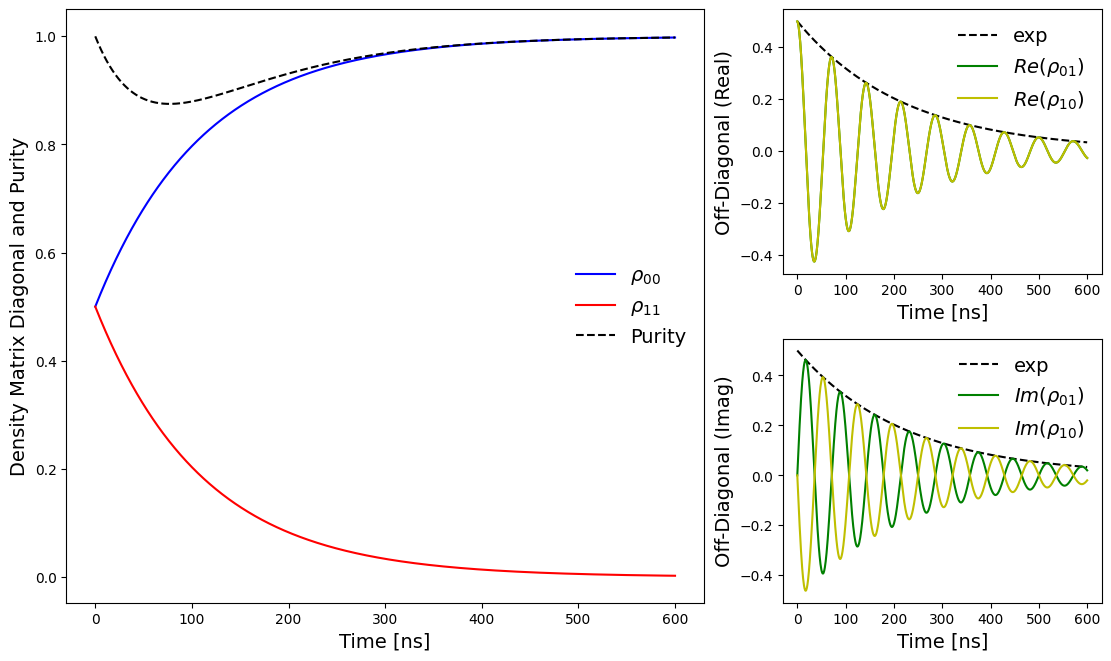

In [6]:
# Plotting

fig = plt.figure(constrained_layout=True, figsize=(11,6.5))
axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[2, 1]})
axs['Left'].plot(sol.t*1e9, np.real(density_matrix_00), label=r"$\rho_{00}$", color='b')
axs['Left'].plot(sol.t*1e9, np.real(density_matrix_11), label=r"$\rho_{11}$", color='r')
#axs['Left'].plot(sol.t*1e9, np.exp(-relaxation_gamma*sol.t)*0.5 + 0.5, label=r"exp", color='y', ls='--')
axs['Left'].plot(sol.t*1e9, purity, label=r"Purity", color='k', ls='--')

axs['TopRight'].plot(sol.t*1e9, np.exp(-relaxation_gamma/2*sol.t)*0.5, label=r"exp", color='k', ls='--')
axs['TopRight'].plot(sol.t*1e9, density_matrix_01.real, label=r"$Re(\rho_{01})$", color='g')
axs['TopRight'].plot(sol.t*1e9, density_matrix_10.real, label=r"$Re(\rho_{10})$", color='y')

axs['BottomRight'].plot(sol.t*1e9, np.exp(-relaxation_gamma/2*sol.t)*0.5, label=r"exp", color='k', ls='--')
axs['BottomRight'].plot(sol.t*1e9, density_matrix_01.imag, label=r"$Im(\rho_{01})$", color='g')
axs['BottomRight'].plot(sol.t*1e9, density_matrix_10.imag, label=r"$Im(\rho_{10})$", color='y')

# Legend Placement
axs['Left'].legend(fontsize=14, frameon=False, loc='center right')#, bbox_to_anchor=(0.7,0.65))
axs['Left'].set_xlabel('Time [ns]', fontsize=14)
axs['Left'].set_ylabel('Density Matrix Diagonal and Purity', fontsize=14)

axs['TopRight'].legend(fontsize=14, frameon=False, loc='upper right')#, bbox_to_anchor=(0.7,0.65))
axs['TopRight'].set_xlabel('Time [ns]', fontsize=14)
axs['TopRight'].set_ylabel('Off-Diagonal (Real)', fontsize=14)

axs['BottomRight'].legend(fontsize=14, frameon=False, loc='upper right')#, bbox_to_anchor=(0.7,0.65))
axs['BottomRight'].set_xlabel('Time [ns]', fontsize=14)
axs['BottomRight'].set_ylabel('Off-Diagonal (Imag)', fontsize=14)


fig.patch.set_alpha(0.0)
axs['Left'].patch.set_alpha(1.0)
axs['TopRight'].patch.set_alpha(1.0)
axs['BottomRight'].patch.set_alpha(1.0)
#plt.savefig("lindblad_plusinitial_decay.pdf", dpi=300, bbox_inches = "tight")
plt.show()